In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

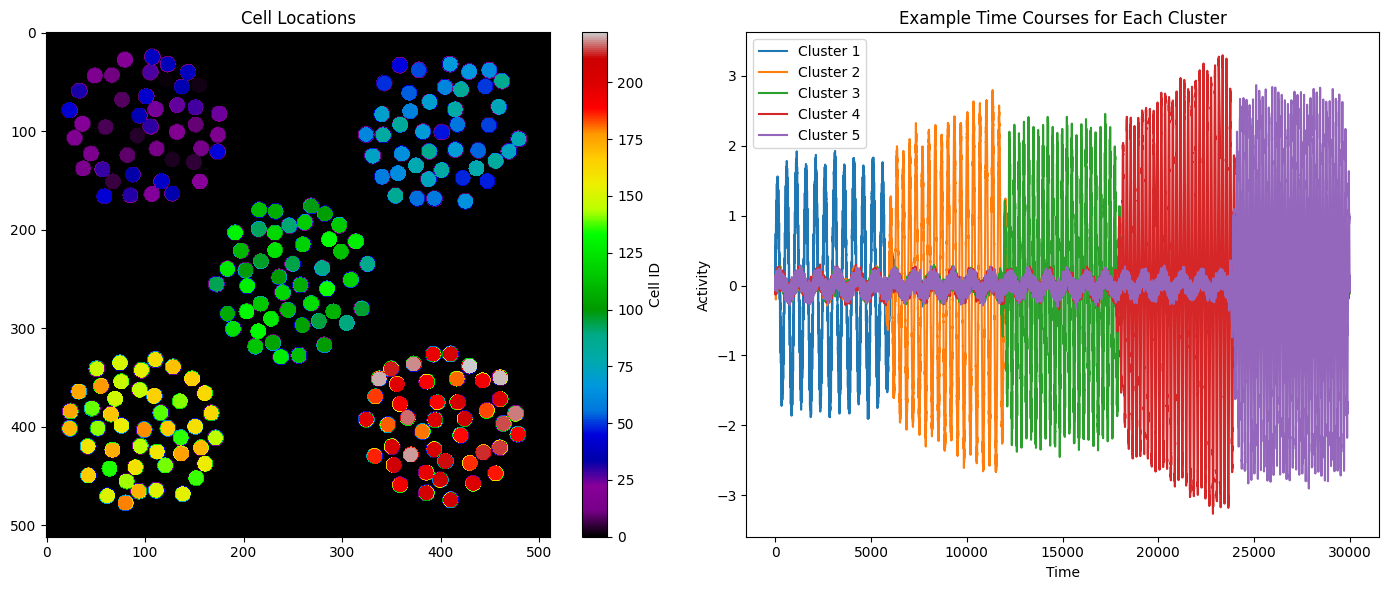

In [21]:
# Generate synthetic data with 5 distinct clusters
# Non-overlapping clusters with distinct temporal patterns so that dbscan can find them

# Parameters
n_neurons = 1000
n_timepoints = 30000
n_clusters = 5
neurons_per_cluster = 200
image_size = 512

# Generate realistic cell locations (same as before)
labelimage = np.zeros((image_size, image_size))
cluster_centers = np.array([
    [100, 100],  # Top left
    [400, 100],  # Top right
    [250, 250],  # Center
    [100, 400],  # Bottom left
    [400, 400]   # Bottom right
])

cell_radius = 8
spacing = 20
cell_id = 1

# Generate cells in clusters
for cluster in range(n_clusters):
    center = cluster_centers[cluster, :]
    n_cells = neurons_per_cluster
    
    radius = 80
    theta = 2 * np.pi * np.random.rand(n_cells)
    r = radius * np.sqrt(np.random.rand(n_cells))
    
    x = center[0] + r * np.cos(theta)
    y = center[1] + r * np.sin(theta)
    
    for i in range(n_cells):
        if (x[i] > cell_radius and x[i] < image_size - cell_radius and
            y[i] > cell_radius and y[i] < image_size - cell_radius):
            
            XX, YY = np.meshgrid(np.arange(image_size), np.arange(image_size))
            cell_mask = ((XX - x[i])**2 + (YY - y[i])**2 <= cell_radius**2)
            
            if not np.any(labelimage[cell_mask] != 0):
                labelimage[cell_mask] = cell_id
                cell_id += 1

# Generate time courses with more distinct temporal patterns
t = np.arange(n_timepoints)
patterns = np.zeros((n_clusters, n_timepoints))

# Define completely separate activity periods for each cluster
activity_periods = [
    (0, 6000),            # Cluster 1: Very early
    (6000, 12000),        # Cluster 2: Early
    (12000, 18000),       # Cluster 3: Middle
    (18000, 24000),       # Cluster 4: Late
    (24000, 30000)        # Cluster 5: Very late
]

# More distinct parameters for each cluster
frequencies = [0.002, 0.003, 0.004, 0.005, 0.006]  # Different frequencies
amplitudes = [1.5, 1.8, 2.0, 2.2, 2.5]            # Different amplitudes
phases = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]  # Different phases

# Generate patterns with smooth onset and offset
for i in range(n_clusters):
    start, end = activity_periods[i]
    
    # Create base pattern with unique characteristics
    t_cluster = t - start  # Time relative to cluster start
    pattern = amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t_cluster + phases[i])
    
    # Create sharp but smooth onset and offset
    onset_width = 1000  # Shorter width for sharper transitions
    onset = 1 / (1 + np.exp(-(t - start) / (onset_width/10)))
    offset = 1 / (1 + np.exp((t - end) / (onset_width/10)))
    
    # Add cluster-specific features
    if i % 2 == 0:  # Even-numbered clusters
        # Add burst-like activity
        burst_freq = 0.05  # High-frequency bursts
        pattern += 0.5 * np.sin(2 * np.pi * burst_freq * t_cluster)
    else:  # Odd-numbered clusters
        # Add ramping behavior
        ramp = np.clip((t - start) / (end - start), 0, 1)
        pattern *= (1 + ramp * 0.5)
    
    # Apply onset and offset
    pattern = pattern * onset * offset
    
    # Add minimal noise
    patterns[i, :] = pattern + 0.1 * np.random.randn(n_timepoints)

# Temporal filtering with shorter kernel for more distinct patterns
tau = 5  # Shorter tau for less smoothing
filter_kernel = np.exp(-np.arange(50) / tau)
filter_kernel = filter_kernel / np.sum(filter_kernel)
base_timecourse = np.zeros((n_clusters, n_timepoints))
for i in range(n_clusters):
    base_timecourse[i, :] = convolve(patterns[i, :], filter_kernel, mode='same')

# Create cluster activity with less noise
timecourse = np.zeros((n_neurons, n_timepoints))
noise_level = 0.05  # Even lower noise level
for i in range(n_clusters):
    cluster_idx = np.arange(i * neurons_per_cluster, (i + 1) * neurons_per_cluster)
    # Add slight variation within cluster but maintain core pattern
    for j, idx in enumerate(cluster_idx):
        variation = 0.1 * np.sin(2 * np.pi * 0.001 * t + j)  # Unique variation for each neuron
        timecourse[idx, :] = base_timecourse[i, :] + variation + \
                            noise_level * np.random.randn(n_timepoints)

# Plot results
plt.figure(figsize=(14, 6))

# Subplot 1: Cell locations
plt.subplot(1, 2, 1)
plt.imshow(labelimage, cmap='nipy_spectral')
plt.title('Cell Locations')
plt.colorbar(label='Cell ID')

# Subplot 2: Example time courses for each cluster
plt.subplot(1, 2, 2)
for i in range(n_clusters):
    plt.plot(t, timecourse[i * neurons_per_cluster, :], label=f'Cluster {i + 1}')
plt.title('Example Time Courses for Each Cluster')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# 1) Calculate correlation coefficients
# Compute pairwise correlations between all cells
corr_matrix = np.corrcoef(timecourse)

# Determine optimal number of clusters using both Elbow method and Silhouette score
k_range = range(2, 21)  # Test cluster numbers from 2 to 20
elbow_values = []
silhouette_values = []

# Iterate through different numbers of clusters to find optimal k
for k in k_range:
    # Perform k-means clustering with 10 different random initializations
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    labels = kmeans.fit_predict(corr_matrix)
    
    # Calculate metrics for determining optimal k
    elbow_values.append(kmeans.inertia_)  # Sum of within-cluster distances for Elbow method
    silhouette_values.append(silhouette_score(corr_matrix, labels))  # Average silhouette score




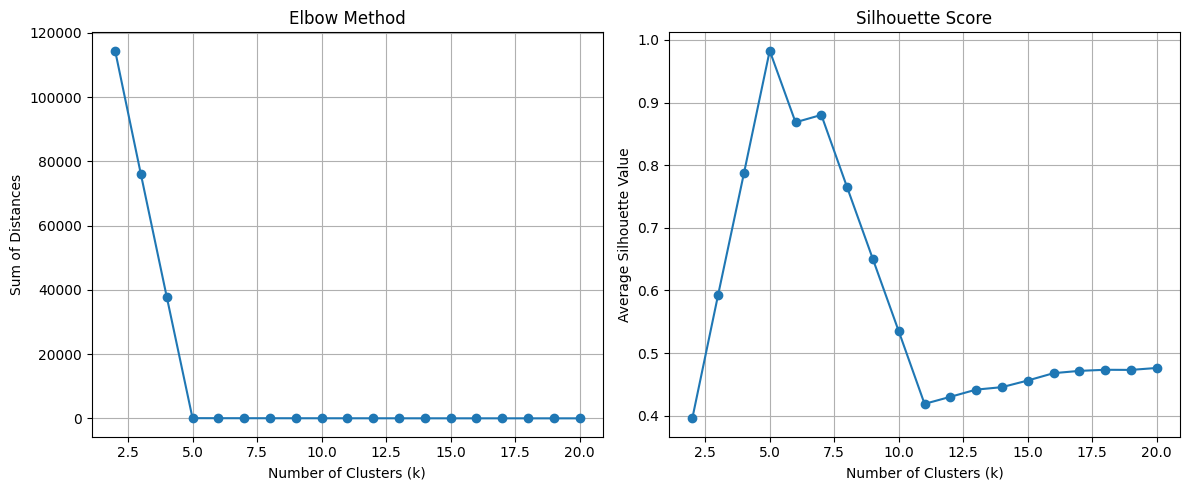

In [23]:
# Visualize cluster evaluation metrics
plt.figure(figsize=(12, 5))

# Plot Elbow method results
plt.subplot(1, 2, 1)
plt.plot(k_range, elbow_values, '-o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Distances')
plt.grid(True)

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_values, '-o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Value')
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
# Automatically select optimal number of clusters
# Choose k with highest silhouette score
best_k_idx = np.argmax(silhouette_values)
k_optimal = k_range[best_k_idx]

# 2) Compare different clustering methods

# Method 1: k-means clustering
# Perform k-means with optimal k and 10 different random initializations
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, random_state=42)
idx_kmeans = kmeans.fit_predict(corr_matrix)

# Method 2: Hierarchical clustering
linkage_method = 'average'  # Use average linkage between clusters
Z = linkage(corr_matrix, method=linkage_method)
idx_hierarchical = fcluster(Z, k_optimal, criterion='maxclust')

# Method 3: DBSCAN (Density-Based Spatial Clustering)
epsilon = 0.5  # Neighborhood radius
minPts = 5     # Minimum points to form a cluster
scaler = StandardScaler()
corr_matrix_scaled = scaler.fit_transform(corr_matrix)
dbscan = DBSCAN(eps=epsilon, min_samples=minPts)
idx_dbscan = dbscan.fit_predict(corr_matrix)

print(f"Number of clusters found by DBSCAN: {len(np.unique(idx_dbscan))}")
print(f"Percentage of noise points: {np.sum(idx_dbscan == -1) / len(idx_dbscan) * 100:.2f}%")

# Store all clustering results in a dictionary
clustering_results = {
    'kmeans': idx_kmeans,
    'hierarchical': idx_hierarchical,
    'dbscan': idx_dbscan
}

# 3) Reorder correlation matrix based on cluster assignments
# Reorder for k-means results
sort_idx_kmeans = np.argsort(idx_kmeans)
sorted_corr_matrix_kmeans = corr_matrix[sort_idx_kmeans][:, sort_idx_kmeans]

# Reorder for hierarchical clustering results
sort_idx_hierarchical = np.argsort(idx_hierarchical)
sorted_corr_matrix_hierarchical = corr_matrix[sort_idx_hierarchical][:, sort_idx_hierarchical]

# Reorder for DBSCAN results
# Note: DBSCAN may identify noise points (labeled as -1)
valid_idx_dbscan = idx_dbscan > -1  # Exclude noise points
sort_idx_dbscan = np.argsort(idx_dbscan[valid_idx_dbscan])
sorted_corr_matrix_dbscan = corr_matrix[valid_idx_dbscan][:, valid_idx_dbscan]
sorted_corr_matrix_dbscan = sorted_corr_matrix_dbscan[sort_idx_dbscan][:, sort_idx_dbscan]

Number of clusters found by DBSCAN: 5
Percentage of noise points: 0.00%


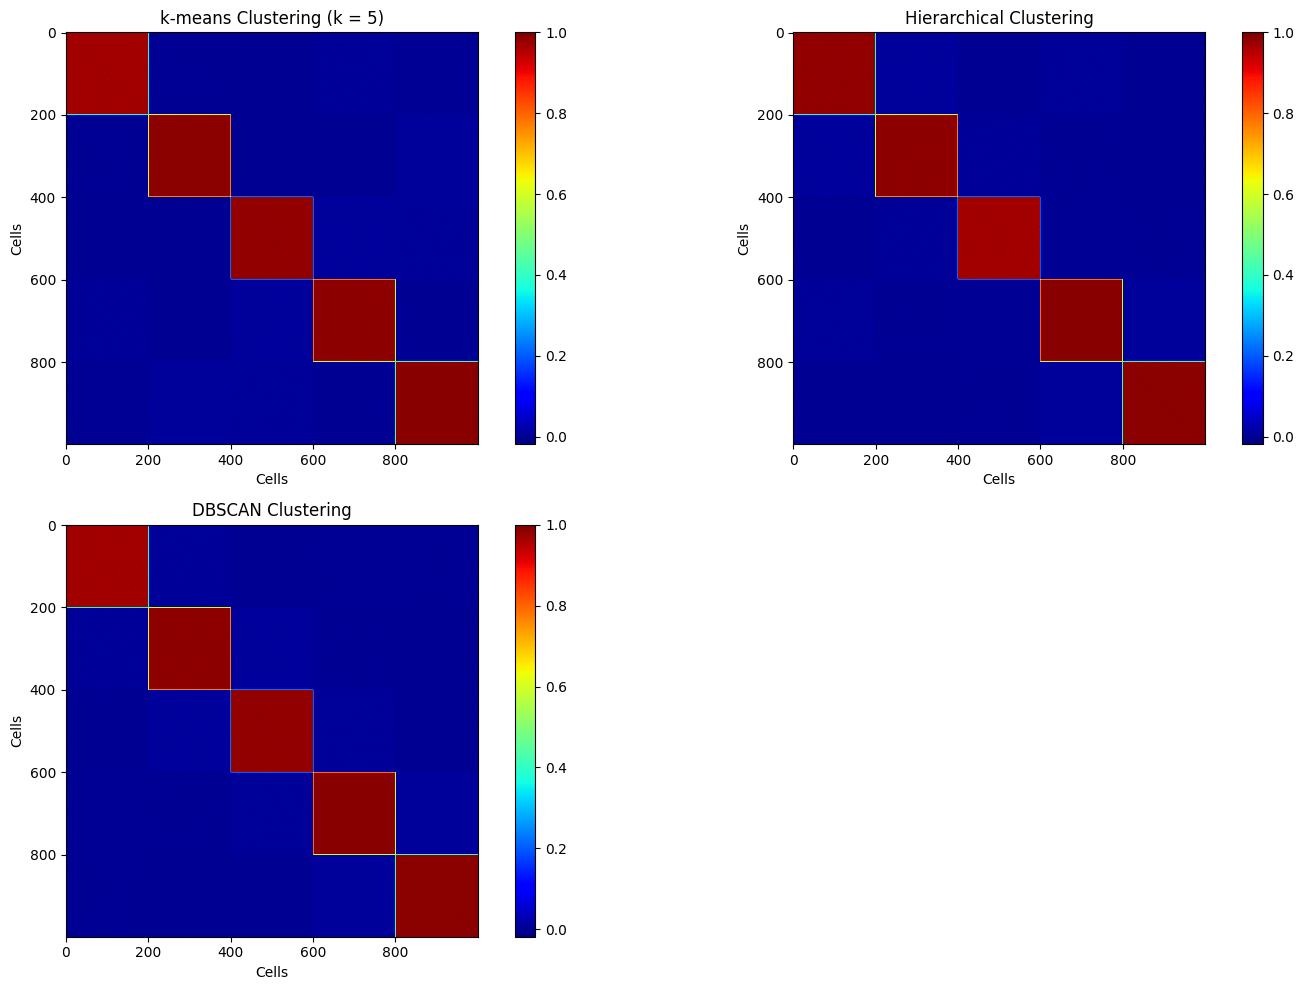

In [26]:
# 4) Visualize clustering results
plt.figure(figsize=(15, 10))

# Plot k-means results
plt.subplot(2, 2, 1)
plt.imshow(sorted_corr_matrix_kmeans, cmap='jet')
plt.colorbar()
plt.title(f'k-means Clustering (k = {k_optimal})')
plt.xlabel('Cells')
plt.ylabel('Cells')

# Plot hierarchical clustering results
plt.subplot(2, 2, 2)
plt.imshow(sorted_corr_matrix_hierarchical, cmap='jet')
plt.colorbar()
plt.title('Hierarchical Clustering')
plt.xlabel('Cells')
plt.ylabel('Cells')

# Plot DBSCAN results
plt.subplot(2, 2, 3)
plt.imshow(sorted_corr_matrix_dbscan, cmap='jet')
plt.colorbar()
plt.title('DBSCAN Clustering')
plt.xlabel('Cells')
plt.ylabel('Cells')

plt.tight_layout()
plt.show()

In [ ]:
# # Save all results to a file for later analysis
# import pickle
# with open('clustering_results.pkl', 'wb') as f:
#     pickle.dump({
#         'clustering_results': clustering_results,
#         'sorted_corr_matrix_kmeans': sorted_corr_matrix_kmeans,
#         'sorted_corr_matrix_hierarchical': sorted_corr_matrix_hierarchical,
#         'sorted_corr_matrix_dbscan': sorted_corr_matrix_dbscan
#     }, f)

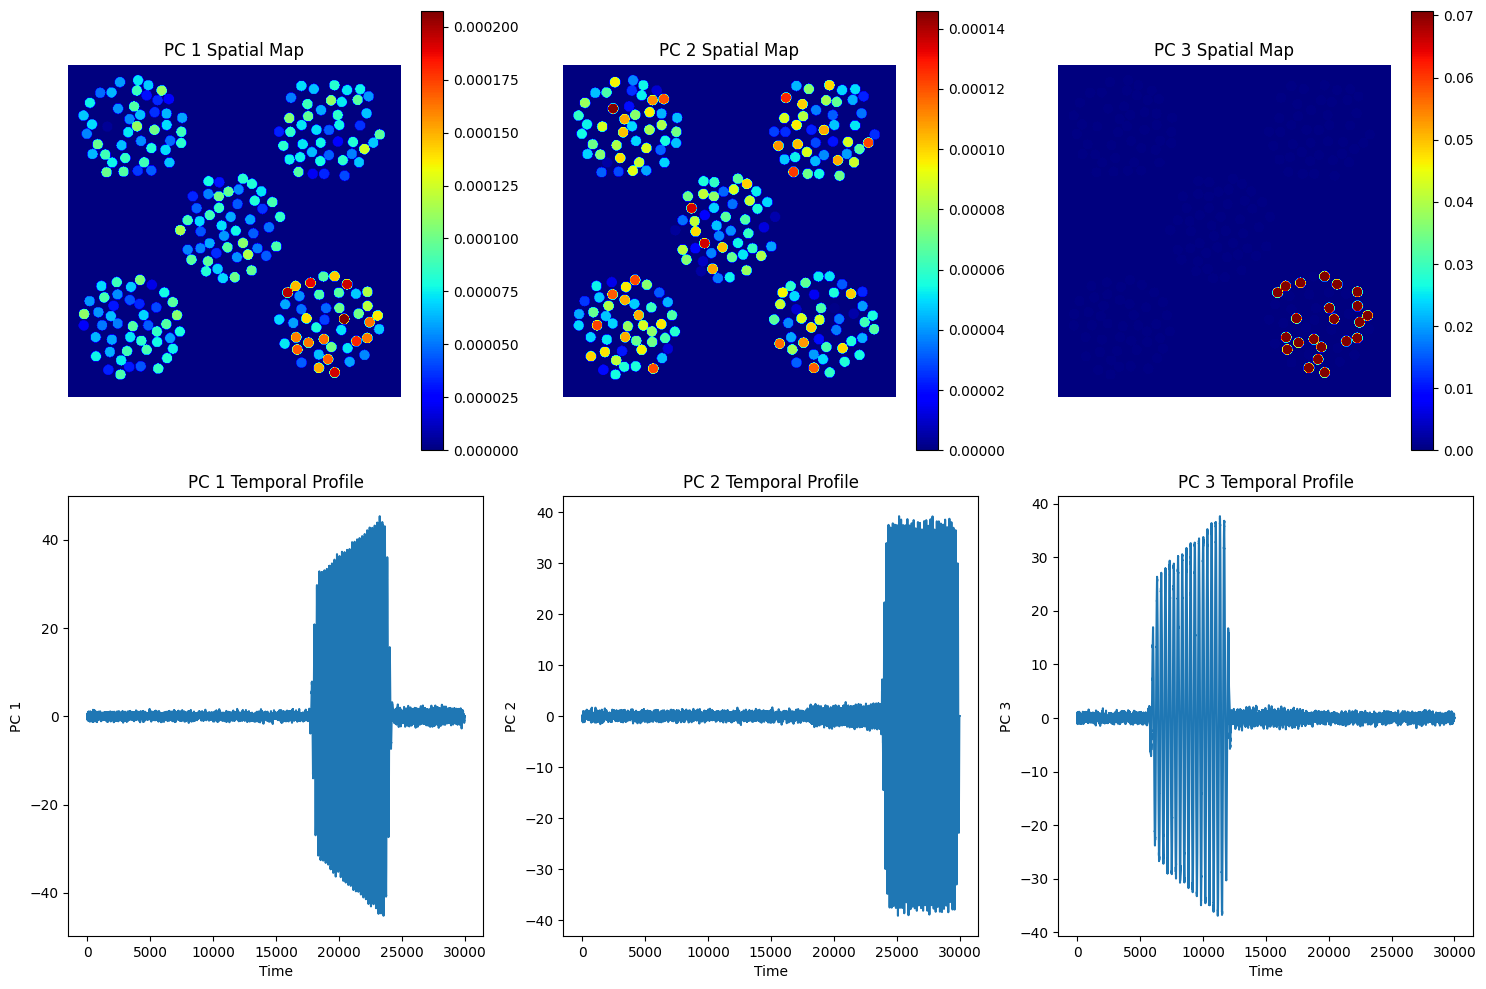

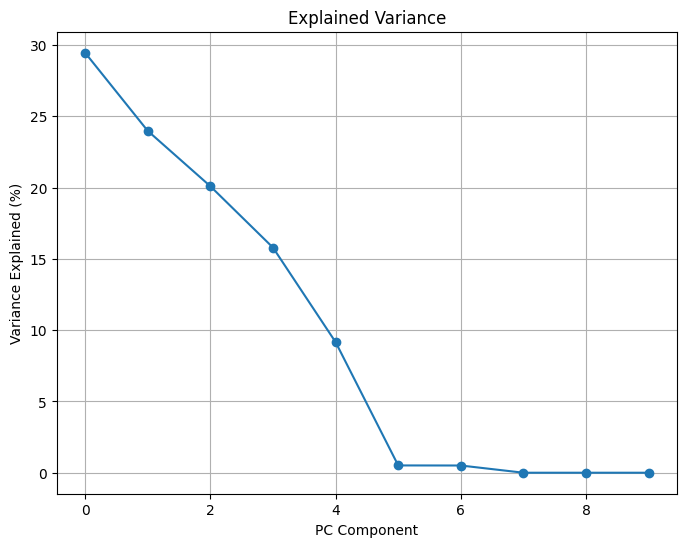

In [30]:
# Perform PCA
pca = PCA()
score = pca.fit_transform(timecourse.T)  # Transpose to match MATLAB's orientation
coeff = pca.components_.T  # Get eigenvectors (components)
explained = pca.explained_variance_ratio_ * 100  # Convert to percentage

# Setup visualization
num_components = 3
fig = plt.figure(figsize=(15, 10))

# Plot spatial maps
for i in range(num_components):
    # Calculate contribution map
    contribution = np.abs(coeff[:, i])
    contribution_map = np.zeros_like(labelimage, dtype=float)
    
    # Fill in contribution map
    for cell_idx in range(1, int(np.max(labelimage)) + 1):
        contribution_map[labelimage == cell_idx] = contribution[cell_idx - 1]
    
    # Create subplot
    ax = plt.subplot(2, num_components, i + 1)
    im = ax.imshow(contribution_map, cmap='jet')
    plt.colorbar(im)
    ax.set_title(f'PC {i+1} Spatial Map')
    ax.axis('off')

# Plot temporal components
for i in range(num_components):
    ax = plt.subplot(2, num_components, i + num_components + 1)
    ax.plot(score[:, i])
    ax.set_xlabel('Time')
    ax.set_ylabel(f'PC {i+1}')
    ax.set_title(f'PC {i+1} Temporal Profile')

plt.tight_layout()

# Create new figure for explained variance
plt.figure(figsize=(8, 6))
plt.plot(explained[:10], '-o')
plt.xlabel('PC Component')
plt.ylabel('Variance Explained (%)')
plt.title('Explained Variance')
plt.grid(True)

plt.show()
